In [ ]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

In [ ]:
!unzip "/content/img.zip"

# Dataset

In [ ]:
class myDataset(Dataset):

    def read_data_set(self):

        all_img_files = self.all_img_files
        imgs = []
        all_labels = []
        for file_name in all_img_files:
            img_path = os.path.join(self.data_set_path, file_name)
            label = torch.tensor(int(file_name[6]))
            imgs.append(img_path)
            all_labels.append(label)

        return imgs, all_labels, len(all_img_files)

    def __init__(self, data_set_path, all_img_files, transforms=None):
        self.data_set_path = data_set_path
        self.all_img_files= all_img_files
        self.image_files_path, self.labels, self.length= self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image,  (self.labels[index])

    def __len__(self):
        return self.length

## Split the dataset into train and valid sets

In [ ]:
import random 

all_img_files = os.listdir("/content/img")
random.shuffle(all_img_files)

In [ ]:
train_image_paths, valid_image_paths = all_img_files[:int(0.8*len(all_img_files))], all_img_files[int(0.8*len(all_img_files)):]

In [ ]:
transforms_train = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])



In [ ]:
train_data_set = myDataset(data_set_path="/content/img",all_img_files=train_image_paths,transforms=transforms_train)
trainloader = DataLoader(train_data_set, batch_size=16, shuffle=True)
valid_data_set = myDataset(data_set_path="/content/img",all_img_files=valid_image_paths,transforms=transforms_train)
validloader = DataLoader(valid_data_set, batch_size=16, shuffle=True)

# Network 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
 

    def forward(self, x):
  
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))
   
        x = x.view(-1, 16* 5 * 5) #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Training

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:

nb_epoch = 30
loss_list = [] 
accuracy_list = []
for epoch in range(nb_epoch):  

    running_loss = 0.0
    nb_data = 0.
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)              # Forward
        loss = criterion(outputs, labels)
        loss.backward()                    # Backward
        optimizer.step()                   # optimize
 

        running_loss += loss.item()
        
        nb_data += 1.
        
    running_loss = running_loss / nb_data
    loss_list.append(running_loss)  
    
    correct = 0.
    total = 0.
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy_list.append(correct / total)
    
    print("Epoch ", epoch, "; train loss = ", running_loss
          , "; accuracy = ", correct / total
          ) 
    
torch.save({
                'nb_epoch': nb_epoch,
                'model' : net.state_dict(),
                'listLoss': loss_list,
            }, "modelNN.pth")

print('Finished Training and save the model as `modelNN.pth`')

Epoch  0 ; train loss =  0.4107859621793032 ; accuracy =  0.8571666666666666
Epoch  1 ; train loss =  0.2874223405936112 ; accuracy =  0.9106666666666666
Epoch  2 ; train loss =  0.21760612073913216 ; accuracy =  0.8973333333333333
Epoch  3 ; train loss =  0.17944213473191484 ; accuracy =  0.944
Epoch  4 ; train loss =  0.1592645052666776 ; accuracy =  0.941
Epoch  5 ; train loss =  0.15198885539143037 ; accuracy =  0.9495
Epoch  6 ; train loss =  0.14614823298311483 ; accuracy =  0.9461666666666667
Epoch  7 ; train loss =  0.13458098075787225 ; accuracy =  0.9486666666666667
Epoch  8 ; train loss =  0.12739220826358844 ; accuracy =  0.9531666666666667
Epoch  9 ; train loss =  0.12537185218930244 ; accuracy =  0.9596666666666667
Epoch  10 ; train loss =  0.11889788429706823 ; accuracy =  0.9558333333333333
Epoch  11 ; train loss =  0.1123458339382584 ; accuracy =  0.9505
Epoch  12 ; train loss =  0.10686136612827007 ; accuracy =  0.9393333333333334
Epoch  13 ; train loss =  0.106977905

# Results

## Loss

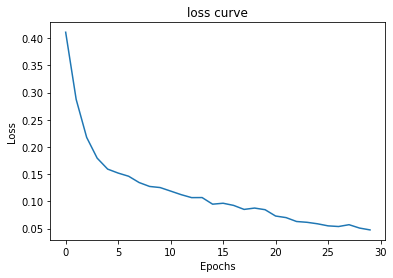

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
plt.plot()
plt.plot(range(len(loss_list)), loss_list)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss curve")

plt.show()

## Accuracy

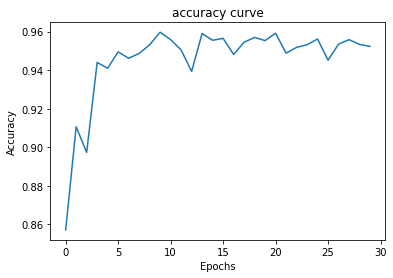

In [ ]:
plt.plot()
plt.plot(range(len(accuracy_list)), accuracy_list)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("accuracy curve")

plt.show()